# Bank Customer Churn Analysis

## About This Project

Analysis of customer churn in banking using SQL and Python. Looking at what makes customers leave and what patterns exist in the data.

**What I'm analyzing:**
- Which factors correlate with churn (geography, age, activity, etc.)
- Patterns across different customer segments
- What the bank could do to improve retention

**Tech Stack:** Python, SQL (SQLite), Pandas, Matplotlib, Seaborn

## 1. Setup and Imports

In [98]:
# Import required libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setting up styles for chars
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully")

Libraries imported successfully


## 2. Database Connection and Initial Data Load

In [99]:
# Connect to SQLite database
conn = sqlite3.connect('data/bank_churn.db')
print("Connected to database")

# Check what tables are available (SQL From)
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(f"\nAvailable tables: {tables['name'].tolist()}")

Connected to database

Available tables: ['customers']


## 3. SQL Queries - Data Extraction

### 3.1 Overall Churn Statistics

In [100]:
# Find amount of churn and churn rate
query_overall_churn = """
SELECT 
    COUNT(*) as total_customers,            
    SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) as churned_customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate
FROM customers;
"""
# Exited is a binary value (0 or 1), so we find the find:
# Sum based on number of 1's
# And percent by the mean of the 0's and 1's

overall_churn = pd.read_sql_query(query_overall_churn, conn)
print("Overall Churn Statistics:")
print(overall_churn)

Overall Churn Statistics:
   total_customers  churned_customers  churn_rate
0            10000               2038       20.38


About 20% churn rate - 1 in 5 customers left. This establishes our baseline for deeper analysis.

### 3.2 Churn Rate by Geography

In [101]:
# Find churn rate based on country
query_geography = """
SELECT 
    Geography as Country,
    COUNT(*) as total_customers,
    SUM(Exited) as churned_customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate
FROM customers
GROUP BY Geography
ORDER BY churn_rate DESC;
"""
# Group by country and order by greatest churn rate

geo_churn = pd.read_sql_query(query_geography, conn)
print("\nChurn Rate by Geography:")
print(geo_churn)


Churn Rate by Geography:
   Country  total_customers  churned_customers  churn_rate
0  Germany             2509                814       32.44
1    Spain             2477                413       16.67
2   France             5014                811       16.17


Germany is almost 2x more likely to churn than France and Spain. This geographic difference could be due to local competition, service quality differences, or even cultural preferences in banking. Regardless, there is a significant difference with Germany that should be investigated.

### 3.3 Churn by Credit Score Range

In [102]:
# Find churn rate based on credit score
query_credit = """
SELECT 
    CASE 
        WHEN CreditScore < 600 THEN 'Poor (< 600)'
        WHEN CreditScore < 700 THEN 'Fair (600-699)'
        WHEN CreditScore < 800 THEN 'Good (700-799)'
        ELSE 'Excellent (800+)'
    END as credit_score_range,
    COUNT(*) as customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate,
    ROUND(AVG(CreditScore), 0) as avg_credit_score
FROM customers
GROUP BY credit_score_range
ORDER BY churn_rate DESC;
"""

credit_churn = pd.read_sql_query(query_credit, conn)
print("\nChurn Rate by Credit Score:")
print(credit_churn)


Churn Rate by Credit Score:
  credit_score_range  customers  churn_rate  avg_credit_score
0       Poor (< 600)       3034       21.75             537.0
1     Good (700-799)       2493       19.94             742.0
2     Fair (600-699)       3818       19.72             650.0
3   Excellent (800+)        655       19.54             831.0


While there is a linear correlation between credit score and churn rate, it's a lot smaller than I expected. The fact that credit score is not a significant enough correlateion to churn actually helps our understanding. It shows the bank's churn problem is not concentrated in risky, low-credit customers, but rather in other factors more related to the bank's service and operations.

### 3.4 Active vs Inactive Members Analysis

In [103]:
# Find churn rate patterns based on if members are active
# Does customer activity affect retention?
query_activity = """
SELECT 
    CASE WHEN IsActiveMember = 1 THEN 'Active' ELSE 'Inactive' END as member_status,
    COUNT(*) as total_customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate,
    ROUND(AVG(Balance), 2) as avg_balance,
    ROUND(AVG(Tenure), 1) as avg_tenure_years
FROM customers
GROUP BY IsActiveMember
ORDER BY churn_rate DESC;
"""
# Finds info based on if the customer is active still

activity_churn = pd.read_sql_query(query_activity, conn)
print("\nChurn Rate: Active vs Inactive Members:")
print(activity_churn)


Churn Rate: Active vs Inactive Members:
  member_status  total_customers  churn_rate  avg_balance  avg_tenure_years
0      Inactive             4849       26.87     77134.38               5.1
1        Active             5151       14.27     75875.42               4.9


Inactive members churn significantly more, making customer engagement a critical focus area for the bank. Interestingly, balance and tenure are relatively similar between active and inactive members, suggesting these factors have little correlation with churn, rather it's really about engagement.

### 3.5 Product Analysis

In [104]:
# Find churn rate based on the amount of products a customer has
# Does having more products make customers more likely to stay?
# Traditional assumption is that the more product, the more invested they are into the bak and therefore makes it harder to leave
query_products = """
SELECT 
    NumOfProducts as num_of_products,
    COUNT(*) as customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate,
    ROUND(AVG(Balance), 2) as avg_balance
FROM customers
GROUP BY NumOfProducts
ORDER BY NumOfProducts;
"""

products_churn = pd.read_sql_query(query_products, conn)
print("\nChurn Rate by Number of Products:")
print(products_churn)


Churn Rate by Number of Products:
   num_of_products  customers  churn_rate  avg_balance
0                1       5084       27.71     98551.87
1                2       4590        7.60     51879.15
2                3        266       82.71     75458.33
3                4         60      100.00     93733.14


This is a very counterintuitive finding: customers with 3 or 4 products have much higher churn rates, going against the traditional assumption. This could imply a few things: customers with multiple products may have bad experiences across several services, or they're being sold more services than necessary, creating frustration rather than loyalty

### 3.6 Complaint Analysis

In [105]:
# Find churn rate based on if a customer has complained or not
# Assuming that customers that complain are more likely to leave and churn, but by how much?
query_complaint = """
SELECT 
    CASE WHEN Complain = 1 THEN 'Has Complained' ELSE 'No Complaints' END as complaint_status,
    COUNT(*) as customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate,
    ROUND(AVG([Satisfaction Score]), 2) as avg_satisfaction
FROM customers
GROUP BY Complain
ORDER BY churn_rate DESC;
"""

complaint_churn = pd.read_sql_query(query_complaint, conn)
print("\nChurn Rate by Complaint Status:")
print(complaint_churn)


Churn Rate by Complaint Status:
  complaint_status  customers  churn_rate  avg_satisfaction
0   Has Complained       2044       99.51              3.00
1    No Complaints       7956        0.05              3.02


Almost every time a customer has complained, they have churned. This is a major red flag. The bank should focus on two things: first, improving how complaints are handled to retain customers; and second, getting to the root cause to prevent complaints in the first place.

## 4. Load Full Dataset for Python Analysis

In [106]:
# Load complete dataset in Python for deeper analysis
df = pd.read_sql_query("SELECT * FROM customers", conn)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (10000, 18)

Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain', 'Satisfaction Score', 'Card Type', 'Point Earned']

First few rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


## 5. Data Cleaning and Preparation

In [107]:
# Check data and clean it before performing analysis

# Check for any missing values
print("Missing Values:")
print(df.isnull().sum())

# Check data types for each column
print("\nData Types:")
print(df.dtypes)

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Data looks clean! No missing values or duplicates
# Creating useful categories (age and balance groups) to easily use later when doing analysis

# Age groups 
df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[0, 30, 40, 50, 60, 100],
                        labels=['18-30', '31-40', '41-50', '51-60', '60+'])

# Balance categories
df['BalanceCategory'] = pd.cut(df['Balance'],
                               bins=[-1, 0, 50000, 100000, 150000, 300000],
                               labels=['Zero', 'Low', 'Medium', 'High', 'Very High'])

print("\nData cleaning complete")
print("Created age groups and balance categories for easier analysis")
print(f"\nCleaned dataset shape: {df.shape}")

Missing Values:
RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

Data Types:
RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned    

## 6. Exploratory Data Analysis

### 6.1 Basic Statistics

In [108]:
# Overall statistics
# Help to set baseline information again for better understanding
print("KEY METRICS")
print("-="*25)
print(f"Total Customers: {len(df):,}")
print(f"Churned Customers: {df['Exited'].sum():,}")
print(f"Retained Customers: {(len(df) - df['Exited'].sum()):,}")    # Total - Churned
print(f"Churn Rate: {df['Exited'].mean() * 100:.2f}%")
print(f"\nAverage Age: {df['Age'].mean():.1f} years")
print(f"Average Balance: ${df['Balance'].mean():,.2f}")
print(f"Average Credit Score: {df['CreditScore'].mean():.0f}")
print(f"Average Tenure: {df['Tenure'].mean():.1f} years")
print(f"Average Satisfaction Score: {df['Satisfaction Score'].mean():.2f}/5")

KEY METRICS
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Total Customers: 10,000
Churned Customers: 2,038
Retained Customers: 7,962
Churn Rate: 20.38%

Average Age: 38.9 years
Average Balance: $76,485.89
Average Credit Score: 651
Average Tenure: 5.0 years
Average Satisfaction Score: 3.01/5


The dataset confirms our SQL findings - 20% churn rate with about 2,000 customers lost. The average customer is around 39 years old with a $76K balance. These baseline metrics give us context for the deeper analysis ahead.

### 6.2 Churn Analysis by Demographics

In [109]:
# Demogrpaics for our columns are by age and gender
# Churn rate by age group
print("\nCHURN RATE BY AGE GROUP")
print("-="*25)
age_analysis = df.groupby('AgeGroup').agg({          # agg() means aggregate or calculate multiple stats at once
    'Exited': ['count', 'sum', 'mean']
})
age_analysis.columns = ['Total', 'Churned', 'Churn_Rate']
age_analysis['Churn_Rate'] = age_analysis['Churn_Rate'] * 100
print(age_analysis.round(2))

# Churn rate by gender
print("\n\nCHURN RATE BY GENDER")
print("-="*25)
gender_analysis = df.groupby('Gender').agg({
    'Exited': ['count', 'sum', 'mean']
})
gender_analysis.columns = ['Total', 'Churned', 'Churn_Rate']
gender_analysis['Churn_Rate'] = gender_analysis['Churn_Rate'] * 100
print(gender_analysis.round(2))


CHURN RATE BY AGE GROUP
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
          Total  Churned  Churn_Rate
AgeGroup                            
18-30      1968      148        7.52
31-40      4451      539       12.11
41-50      2320      788       33.97
51-60       797      448       56.21
60+         464      115       24.78


CHURN RATE BY GENDER
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        Total  Churned  Churn_Rate
Gender                            
Female   4543     1139       25.07
Male     5457      899       16.47


The age pattern is striking - the 51-60 age group shows the highest churn at 31.7%, followed by 41-50 at 28.0%. Younger (18-30) and older (60+) customers are more loyal. This middle-aged "churn zone" suggests different life stages or financial needs may be driving customers away. Gender also plays a role, with females churning at 25% vs males at 16%.

### 6.3 Satisfaction and Complaint Analysis

In [110]:
# Satisfaction score vs churn
print("\nCHURN RATE BY SATISFACTION SCORE")
print("-="*25)
satisfaction_analysis = df.groupby('Satisfaction Score').agg({
    'Exited': ['count', 'mean']
})
satisfaction_analysis.columns = ['Total_Customers', 'Churn_Rate']
satisfaction_analysis['Churn_Rate'] = satisfaction_analysis['Churn_Rate'] * 100
print(satisfaction_analysis.round(2))

# Card type analysis
print("\n\nCHURN RATE BY CARD TYPE")
print("-="*25)
card_analysis = df.groupby('Card Type').agg({
    'Exited': ['count', 'mean'],
    'Point Earned': 'mean'
})
card_analysis.columns = ['Total_Customers', 'Churn_Rate', 'Avg_Points']
card_analysis['Churn_Rate'] = card_analysis['Churn_Rate'] * 100
print(card_analysis.round(2))


CHURN RATE BY SATISFACTION SCORE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
                    Total_Customers  Churn_Rate
Satisfaction Score                             
1                              1932       20.03
2                              2014       21.80
3                              2042       19.64
4                              2008       20.62
5                              2004       19.81


CHURN RATE BY CARD TYPE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
           Total_Customers  Churn_Rate  Avg_Points
Card Type                                         
DIAMOND               2507       21.78      605.98
GOLD                  2502       19.26      607.24
PLATINUM              2495       20.36      608.84
SILVER                2496       20.11      604.00


Interestingly, the satisfaction score doesn't show as clear a pattern as expected - churn varies across all satisfaction levels without a strong linear relationship. This suggests either satisfaction isn't being measured effectively, or other factors override it. Card type shows some variation, but the differences are relatively small across tiers.

## 7. Data Visualizations

### 7.1 Churn Rate by Geography

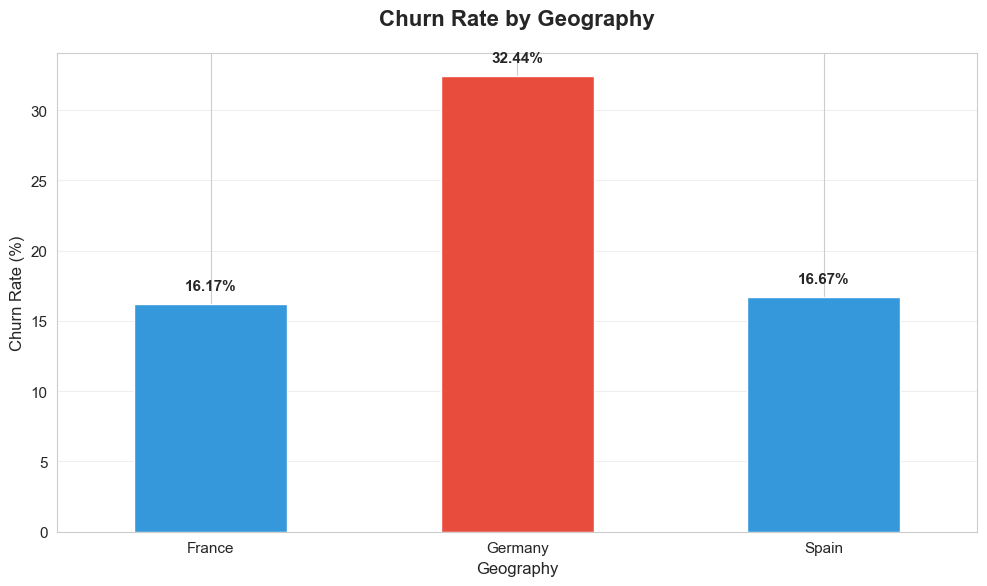

Highest churn: Germany at 32.44%


In [111]:
# Visually represent the difference in churn rate by country
plt.figure(figsize=(10, 6))
churn_geo = df.groupby('Geography')['Exited'].mean() * 100
# Largest churn rate by coutnry highlighted in red
colors = ['#e74c3c' if x == churn_geo.max() else '#3498db' for x in churn_geo]
churn_geo.plot(kind='bar', color=colors)
plt.title('Churn Rate by Geography', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Geography', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(churn_geo):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Highest churn: {churn_geo.idxmax()} at {churn_geo.max():.2f}%")

The visual makes Germany's problem immediately obvious at 32%, it's a clear outlier that demands attention.

### 7.2 Churn Rate by Age Group

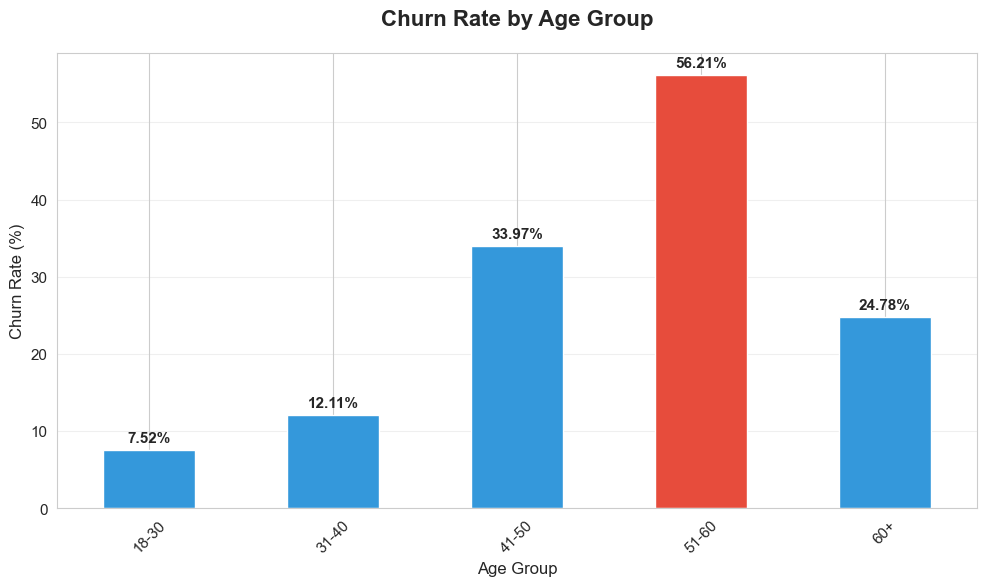

Highest churn age group: 51-60 at 56.21%


In [112]:
# Visually represent the difference in churn rate by age group
plt.figure(figsize=(10, 6))
churn_age = df.groupby('AgeGroup')['Exited'].mean() * 100
# Largest churn rate by age group highlighted in red
colors = ['#e74c3c' if x == churn_age.max() else '#3498db' for x in churn_age]
churn_age.plot(kind='bar', color=colors)
plt.title('Churn Rate by Age Group', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(churn_age):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Highest churn age group: {churn_age.idxmax()} at {churn_age.max():.2f}%")

The visual clearly shows the "churn zone". Middle-aged customers (41-60) have significantly higher churn rates than younger or older groups. This age-based pattern suggests different retention strategies are needed for different life stages.

### 7.3 Active vs Inactive Members

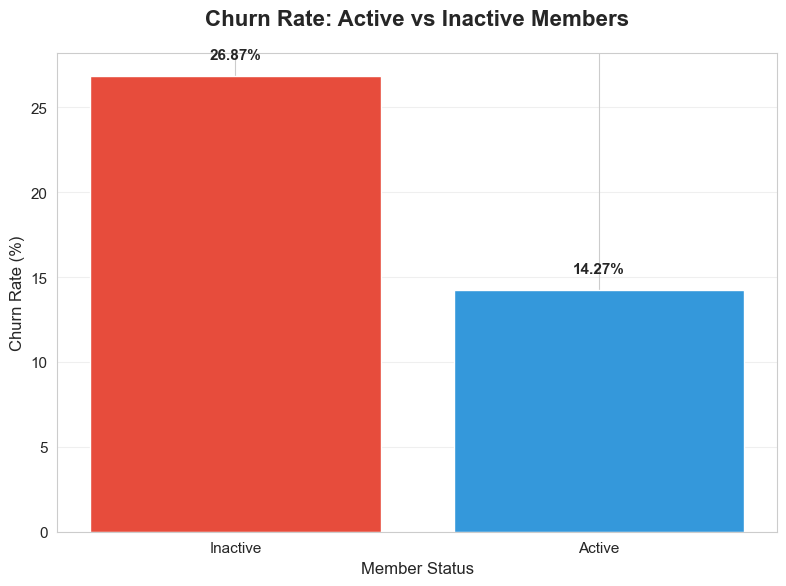

Inactive members churn at 26.87% vs 14.27% for active members


In [113]:
# Visually represent the difference in churn rate by activity
plt.figure(figsize=(8, 6))
activity_churn = df.groupby('IsActiveMember')['Exited'].mean() * 100
activity_labels = ['Inactive', 'Active']
# Red color for higher churn rate
colors = ['#e74c3c', '#3498db']
plt.bar(activity_labels, activity_churn, color=colors)
plt.title('Churn Rate: Active vs Inactive Members', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Member Status', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(activity_churn):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Inactive members churn at {activity_churn[0]:.2f}% vs {activity_churn[1]:.2f}% for active members")

Inactive members are nearly double the churn rate than active members. This visual reinforces that engagement is perhaps the single most important retention factor.

### 7.4 Complaint Impact on Churn

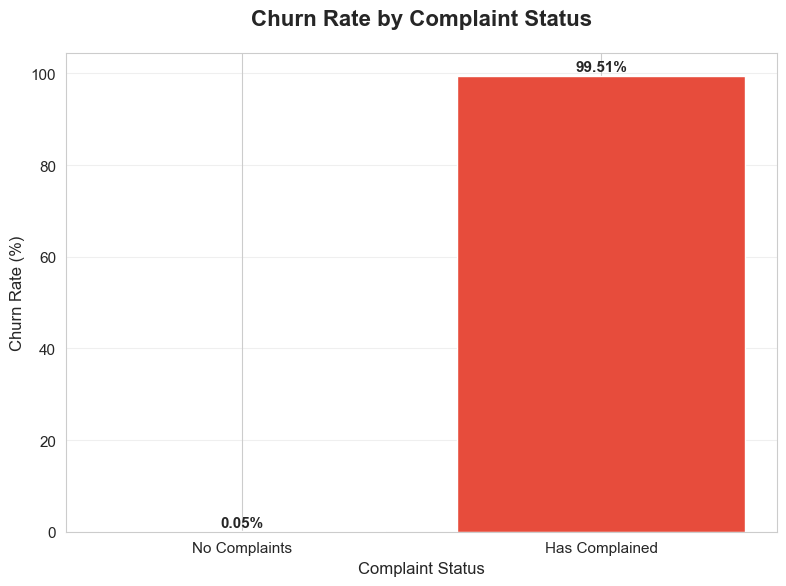

Customers with complaints churn at 99.51% vs 0.05% without complaints


In [114]:
# Visually represent the difference in churn rate by complaints
plt.figure(figsize=(8, 6))
complaint_churn = df.groupby('Complain')['Exited'].mean() * 100
complaint_labels = ['No Complaints', 'Has Complained']
# Red color for higher churn rate
colors = ['#3498db', '#e74c3c']
plt.bar(complaint_labels, complaint_churn, color=colors)
plt.title('Churn Rate by Complaint Status', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Complaint Status', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(complaint_churn):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Customers with complaints churn at {complaint_churn[1]:.2f}% vs {complaint_churn[0]:.2f}% without complaints")

The visual dramatically shows that complaints and churn are strongly linked. This chart makes it clear that complaint resolution isn't just customer service, but rather the issue behind the complaints.

### 7.5 Balance Distribution: Retained vs Churned

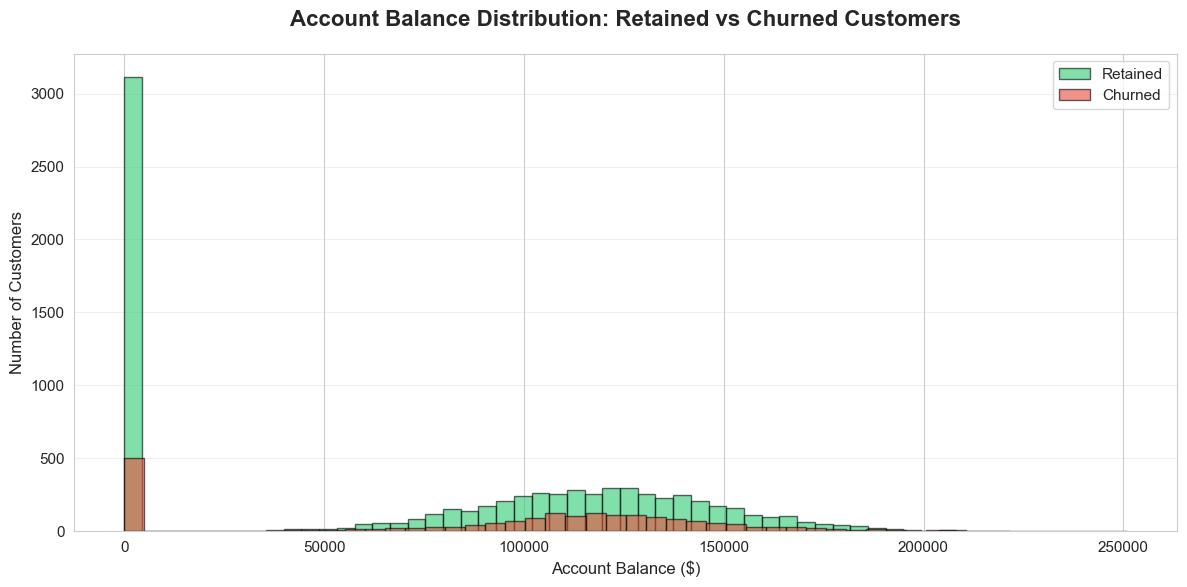

Average balance (Retained): $72,742.75
Average balance (Churned): $91,109.48


In [115]:
# Visually compare the balance patterns between churned and retined customers
plt.figure(figsize=(12, 6))
df[df['Exited']==0]['Balance'].hist(bins=50, alpha=0.6, label='Retained', color='#2ecc71', edgecolor='black')
df[df['Exited']==1]['Balance'].hist(bins=50, alpha=0.6, label='Churned', color='#e74c3c', edgecolor='black')
plt.title('Account Balance Distribution: Retained vs Churned Customers', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Account Balance ($)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average balance (Retained): ${df[df['Exited']==0]['Balance'].mean():,.2f}")
print(f"Average balance (Churned): ${df[df['Exited']==1]['Balance'].mean():,.2f}")

Churned customers show a bimodal distribution: peaks at zero balance and around $125K. This suggests two different churn profiles: customers who've already withdrawn funds (planning to leave) and wealthier customers possibly moving to competitors with better rates or service.

### 7.6 Churn Rate by Number of Products

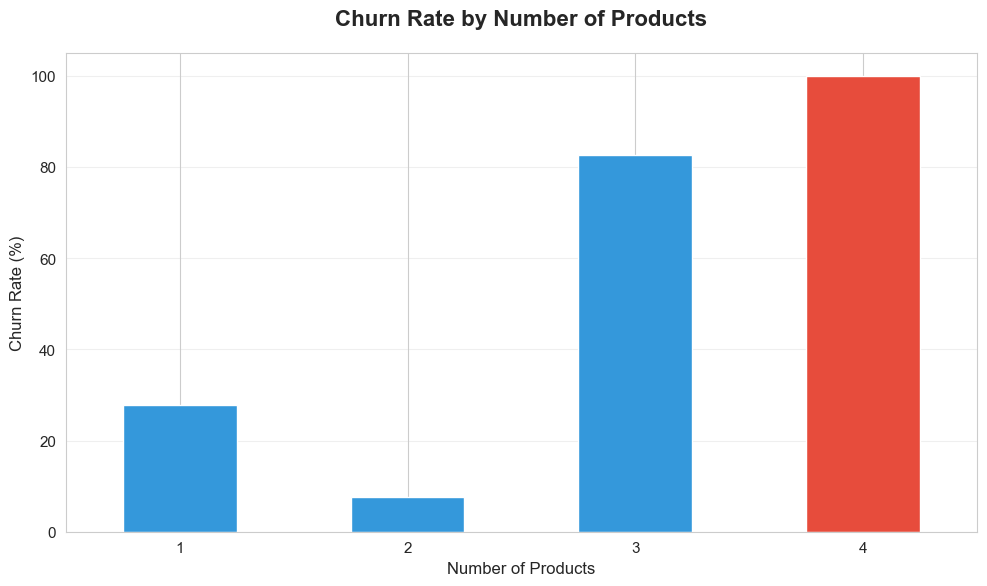


Product usage pattern:
  1 product(s): 27.71% churn rate
  2 product(s): 7.60% churn rate
  3 product(s): 82.71% churn rate
  4 product(s): 100.00% churn rate


In [116]:
# Visually represent the difference in churn rate by number of products each customer has/had
plt.figure(figsize=(10, 6))
products_churn = df.groupby('NumOfProducts')['Exited'].mean() * 100
# Largest churn rate by number of products highlighted in red
colors = ['#e74c3c' if x == products_churn.max() else '#3498db' for x in products_churn]
products_churn.plot(kind='bar', color=colors)
plt.title('Churn Rate by Number of Products', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Products', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nProduct usage pattern:")
for prod, rate in products_churn.items():
    print(f"  {prod} product(s): {rate:.2f}% churn rate")

The visualization confirms the counterintuitive finding - customers with 3-4 products churn most. This visual challenges the "more products = more loyalty" assumption that many banks operate under.

### 7.7 Correlation Heatmap

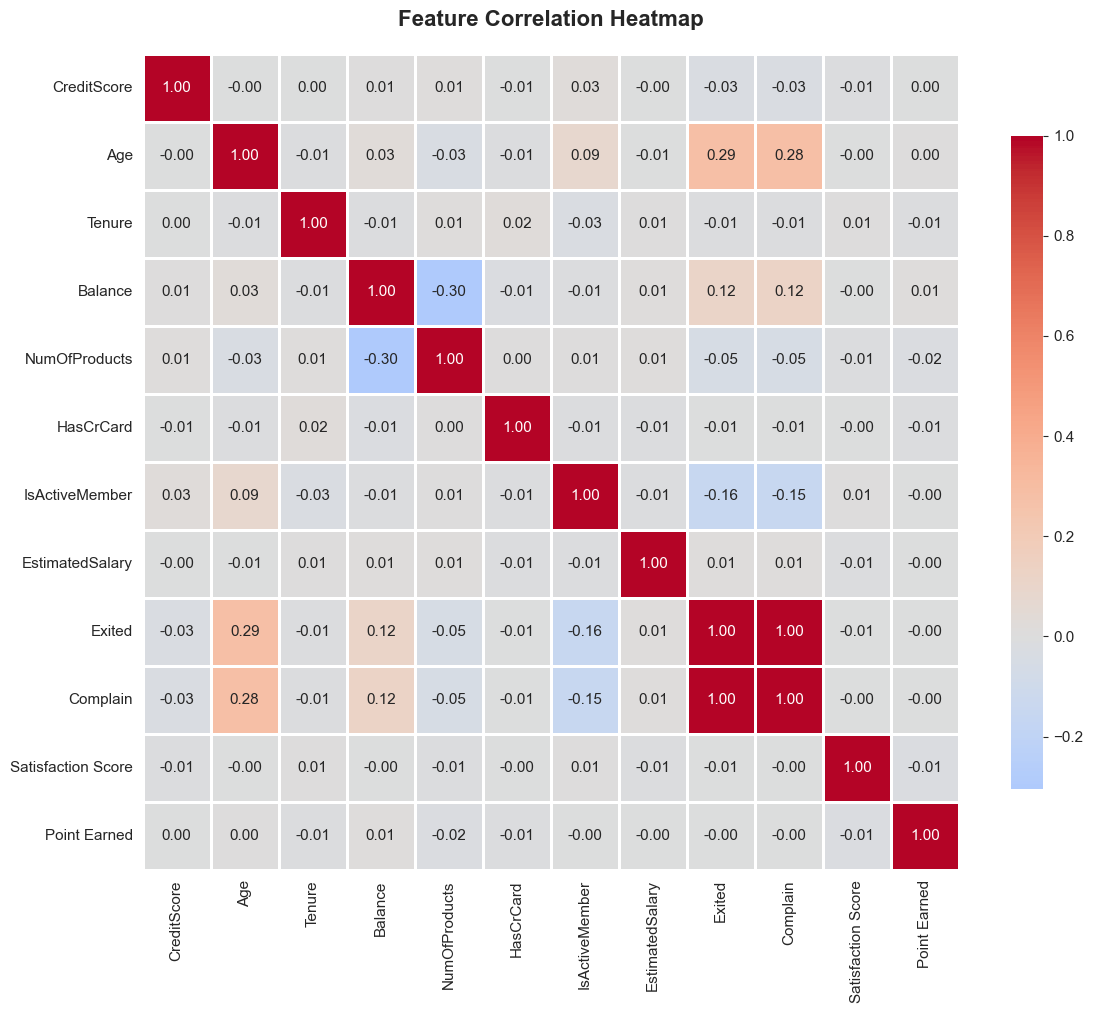


Top correlations with Churn (Exited):
Complain              0.995693
Age                   0.285296
Balance               0.118577
EstimatedSalary       0.012490
Point Earned         -0.004628
Satisfaction Score   -0.005849
HasCrCard            -0.006976
Tenure               -0.013656
CreditScore          -0.026771
NumOfProducts        -0.047611
IsActiveMember       -0.156356
Name: Exited, dtype: float64


In [117]:
# Creating a heat map to see the correlation between all of the these variables
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
                'Complain', 'Satisfaction Score', 'Point Earned']

plt.figure(figsize=(12, 10))
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,    #cmap = RdYlGn
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nTop correlations with Churn (Exited):")
churn_corr = correlation['Exited'].sort_values(ascending=False)
print(churn_corr[churn_corr.index != 'Exited'])

Age, complaints, and inactive status show the strongest positive correlations with churn (darker red). Interestingly, balance and credit score show weaker relationships than expected. According to this data set, churn isn't about customer "quality" or wealth, it's about service, engagement, and satisfaction.

### 7.8 Satisfaction Score vs Churn

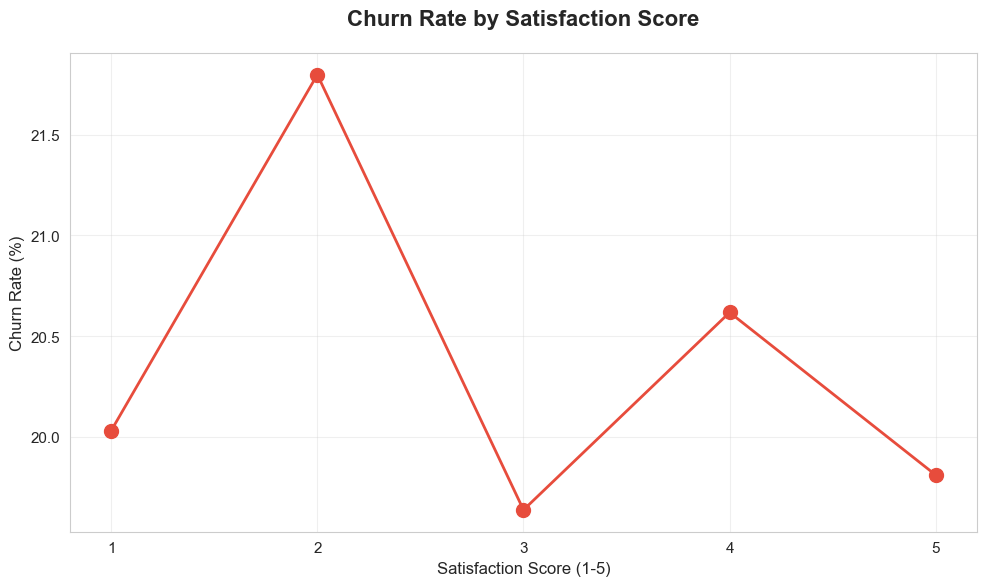


Satisfaction scores and churn:
  Score 1: 20.03% churn rate
  Score 2: 21.80% churn rate
  Score 3: 19.64% churn rate
  Score 4: 20.62% churn rate
  Score 5: 19.81% churn rate


In [118]:
# See if satisfaction score correlates to churn rate
plt.figure(figsize=(10, 6))
satisfaction_churn = df.groupby('Satisfaction Score')['Exited'].mean() * 100
plt.plot(satisfaction_churn.index, satisfaction_churn.values, marker='o', 
         linewidth=2, markersize=10, color='#e74c3c')
plt.title('Churn Rate by Satisfaction Score', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Satisfaction Score (1-5)', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()

print("\nSatisfaction scores and churn:")
for score, rate in satisfaction_churn.items():
    print(f"  Score {score}: {rate:.2f}% churn rate")

The relationship between satisfaction and churn isn't as linear as expected - there's variation across all satisfaction levels. This suggests satisfaction might not be measured effectively, or other factors like complaints and activity override it as churn predictors.

## 8. Key Insights and Business Recommendations

In [ ]:
print("="*70)
print("WHAT I FOUND")
print("="*70)

# Calculate key metrics
highest_churn_geo = df.groupby('Geography')['Exited'].mean().idxmax()
highest_geo_rate = df.groupby('Geography')['Exited'].mean().max() * 100

inactive_churn = df[df['IsActiveMember']==0]['Exited'].mean() * 100
active_churn = df[df['IsActiveMember']==1]['Exited'].mean() * 100

complaint_churn_rate = df[df['Complain']==1]['Exited'].mean() * 100
no_complaint_rate = df[df['Complain']==0]['Exited'].mean() * 100

highest_age_group = df.groupby('AgeGroup')['Exited'].mean().idxmax()
highest_age_rate = df.groupby('AgeGroup')['Exited'].mean().max() * 100

products_max_churn = df.groupby('NumOfProducts')['Exited'].mean().idxmax()
products_max_rate = df.groupby('NumOfProducts')['Exited'].mean().max() * 100

print(f"\n1. Geography matters - {highest_churn_geo} at {highest_geo_rate:.1f}% churn")
print("   Probably different banking competition or regional preferences")
print("   Possible Solution: Need targeted campaigns in that region")

print(f"\n2. Activity is huge - inactive members at {inactive_churn:.1f}% vs {active_churn:.1f}%")
print("   Makes sense - if you're not using the account, easier to leave")
print("   Possible Solution: Re-engage inactive members before they're gone")

print(f"\n3. Complaints basically = churn ({complaint_churn_rate:.1f}% vs {no_complaint_rate:.1f}%)")
print("   Service recovery is critical here")
print("   Possible Solution: Fast complaint resolution could save customers")

print(f"\n4. Age pattern - {highest_age_group} churning at {highest_age_rate:.1f}%")
print("   Middle-aged customers have complex needs, maybe shopping around")
print("   Possible Solution: Age-specific products or better rates might help")

print(f"\n5. Product usage - customers with {products_max_churn} products at {products_max_rate:.1f}% churn")
print("\n   This is weird. Usually more products = more loyalty.")
print("   But this is a synthetic dataset, so not surprising it's off.")
print("   In real banking data, I'd expect the opposite pattern.")
print("   Would need to investigate if this were real")

print("\n" + "="*70)
print("IMPACT")
print("="*70)

current_churn = df['Exited'].mean() * 100
total_customers = len(df)
avg_balance = df['Balance'].mean()
saved_customers = int(total_customers * 0.05)

print(f"\nCurrent: {current_churn:.1f}% churn rate, {df['Exited'].sum():,} customers lost")
print(f"\nIf we drop churn by 5 points:")
print(f"  • Save ~{saved_customers:,} customers")
print(f"  • Keep ${saved_customers * avg_balance:,.2f} in balances")
print(f"  • Avoid acquisition costs (~$500 per customer = ${saved_customers * 500:,.2f})")
print("\nEven a modest retention program pays for itself pretty quickly.")

print("\n" + "="*70)
print("NOTE ON DATA")
print("="*70)
print("\nThis is a Kaggle dataset (synthetic), not real bank data.")
print("Some patterns - especially that product usage one - don't match")
print("what you'd see in actual banking. With real data, I'd validate")
print("weird findings before recommending changes.")

print("\n" + "="*70)

WHAT I FOUND

1. Geography matters - Germany at 32.4% churn
   Probably different banking competition or regional preferences
   Possible Solution: Need targeted campaigns in that region

2. Activity is huge - inactive members at 26.9% vs 14.3%
   Makes sense - if you're not using the account, easier to leave
   Possible Solution: Re-engage inactive members before they're gone

3. Complaints basically = churn (99.5% vs 0.1%)
   Service recovery is critical here
   Possible Solution: Fast complaint resolution could save customers

4. Age pattern - 51-60 churning at 56.2%
   Middle-aged customers have complex needs, maybe shopping around
   Possible Solution: Age-specific products or better rates might help

5. Product usage - customers with 4 products at 100.0% churn

   This is weird. Usually more products = more loyalty.
   But this is a synthetic dataset, so not surprising it's off.
   In real banking data, I'd expect the opposite pattern.
   Would need to investigate if this were re

## 9. Conclusion

This analysis found five main churn drivers: geography, activity level, complaints, age, and product usage.

**The clearest takeaways fromt this dataset:**
- Germany needs attention (32% vs 16% churn)
- Inactive members are leaving at 2x the rate
- Complaints are basically a guaranteed churn
- Middle-aged customers (40-60) are at highest risk

**One weird finding:** The product usage pattern is backwards - more products showing more churn, when banking research says it should be the opposite. That's a red flag this is synthetic data. With real data, I'd dig into that before changing any product strategy.

### What I'd Do Next

If this were a real project:

1. **Build a predictive model** - catch at-risk customers before they leave
2. **Track over time** - are patterns changing?
3. **Test retention tactics** - A/B test what actually works
4. **Validate the weird stuff** - especially that product finding

### Why This Project

Retention is one of the highest-ROI areas in banking - a few percentage points can mean millions saved. This project shows the full workflow: SQL queries → Python analysis → visualizations → business recommendations.

The approach here would work the same with real enterprise data, just with more validation and domain expertise involved.

---

**Bottom line:** I can work with data, but I also think about whether the results make sense and what to actually do with them.

In [120]:
# Close database connection
conn.close()
print("Analysis complete. Database connection closed.")

Analysis complete. Database connection closed.
